In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.transforms import transforms

import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt

from rnn_gmm import RnnGmm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
def get_mnist(batch_size):
  transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.30811,)),
      transforms.Lambda(lambda x: torch.flatten(x))
      # transforms.Lambda(lambda x: torch.unsqueeze(x,0))
    ]
  )

  train_set = tv.datasets.MNIST(
    'data/', train=True, download=True, transform=transform
  )
  test_set = tv.datasets.MNIST(
    'data/', train=False, download=True, transform=transform
  )

  train_loader = torch.utils.data.DataLoader(
    train_set, batch_size
  )
  test_loader = torch.utils.data.DataLoader(
    test_set, batch_size
  )

  return train_loader, test_loader, train_set, test_set
batch_size = 10
train_loader, test_loader, train_set, test_set = get_mnist(batch_size)

In [14]:
model = RnnGmm(
  28*28, 28, 32, 10, device
).to(device)
model.load_state_dict(torch.load('chkpt/large_rnngmm_1e-05.tar')['model_state_dict'])

<All keys matched successfully>

In [15]:
item = torch.stack((train_set[0][0],train_set[1][0],train_set[1][0]))
item = item.to(device)
mask = torch.round(torch.rand(item.size(1))).to(device)

samples = model.sample(3, item, mask)

In [16]:
sample = model.sample(3)

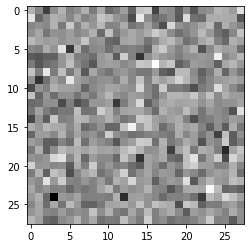

In [17]:
new = sample[0].detach().cpu().numpy()

plt.imshow(new.reshape((28,28)), cmap='gray')
plt.show()

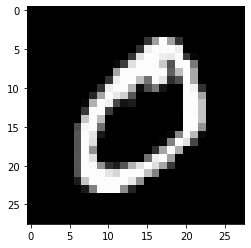

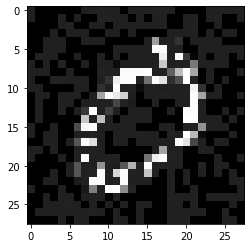

In [18]:
new = samples[1].detach().cpu().numpy()
to_impute = item[1].detach().cpu().numpy()

plt.imshow(to_impute.reshape((28,28)), cmap='gray')
plt.show()

item[1][torch.gt(1-mask, 0)] = samples[1]
to_impute = item[1].detach().cpu().numpy()

plt.imshow(to_impute.reshape((28,28)), cmap='gray')
plt.show()

In [12]:
def logsumexp(x, dim, keepdim=True):
  c = torch.max(x, dim=dim).values
  exp_ = torch.transpose(torch.exp(torch.transpose(x,0,1) - c),0,1)
  sum_exp = torch.sum(exp_,dim=dim)
  return c + torch.log(sum_exp)

def log_prob(x, means, covs, pis):
  covs = F.softplus(covs)
  pis = F.relu(pis)
  pis = torch.transpose(torch.transpose(pis,0,1) * torch.sum(pis,dim=1),0,1)
  exp_cov = torch.exp(1./torch.sqrt(covs))
  numer = -.5*(means*means + x*x - 2*x*means) 
  log_p = logsumexp(numer / covs * exp_cov, dim=1, keepdim=True)

  return log_p

x = torch.rand((5,1))*100
means = torch.randn((5,10))*10
covs = torch.rand((5,10))
pis = torch.rand((5,10))

torch.exp(log_prob(x,means,covs,pis))

tensor([0.0000e+00, 1.0000e+00, 9.7562e-01, 0.0000e+00, 1.2468e-05])